# Check Spark configuration

In [1]:
from pyspark import SparkConf
SparkConf().getAll()

[('spark.driver.memory', '20g'),
 ('spark.executor.memory', '10g'),
 ('spark.master', 'local[3]'),
 ('spark.local.dir', 'D:/PySparkTmp'),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.memoryOverhead', '10g'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.maxResultSize', '5g')]

# Data Engineering

## Read Data

Twitter data source is available from http://help.sentiment140.com/for-students

In [2]:
from pyspark.sql.functions import col
df = spark.read.csv('trainingandtestdata/training.1600000.processed.noemoticon.csv')
df = df.select(col('_c5').alias('text'), col('_c0').alias('target'))

In [3]:
df.count()

1600000

In [4]:
df.select("text", "target").show(20, False)

+---------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |
|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!      |
|@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                            |
|my whole body feels itchy and like its on fire                                                                       |
|@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.       |
|@Kwesidei not the whole crew           

## Clean data
* remove url link
* remove @mention, \#hashTag, <word\>
* remove [\*] with one word included, such as [-o], [twitter], [*.com]
* remove \$ + number, such as $12,000
* remove words having special unicode character, such as U+FFFD
* string lower case, strip spaces
* html unquote, such as transforming &amp\; to &;
* replace sad face: replace "=\[", "=\(", ":(", ":-\[", ":\[" by "sad"
* replace happy face: replace ":)", ": )", ":\]" by "happy"
* replace "'s " by " is "
* replace *'t into two words, such as don't -> do not
* keep only letters [a-zA-Z]
* drop Null data
* add "End-Of-Sentence" word
* remove extra spaces

In [3]:
from pyspark.sql.functions import regexp_replace, udf
from pyspark.sql.types import StringType
import html
import re
df = df.withColumn('text', regexp_replace('text', 'https?://[\w\d./_?=]+', ''))
df = df.withColumn('text', regexp_replace('text', 'www.[\w\d./_?=]+', ''))
df = df.withColumn('text', regexp_replace('text', "\@[\w\d.'_]+", ''))
df = df.withColumn('text', regexp_replace('text', "\#[\w\d.'_]+", ''))
df = df.withColumn('text', regexp_replace('text', "\<[\w]+\>+", ''))
df = df.withColumn('text', regexp_replace('text', "\[[\S\w\d:.-]+\]", ''))
df = df.withColumn('text', regexp_replace('text', "\$\d+,? ?\d*", ''))
df = df.withColumn('text', regexp_replace('text', "(=\[|=\(|:\-\[|:\[)", 'sad'))
df = df.withColumn('text', regexp_replace('text', "(: ?\)|: ?\])", 'happy'))
df = df.withColumn('text', regexp_replace('text', "'s ", ' is '))
df = df.withColumn('text', regexp_replace('text', "'m ", ' am '))
df = df.withColumn('text', regexp_replace('text', "'re ", ' are '))


dataClean = udf(lambda x: html.unescape(x).lower().strip(), StringType())
#removeUnicode = udf(lambda x: re.sub("[\w]*"+u"\uFFFD ?"+ "([\w]+|$)", "", x), StringType())
removeUnicode = udf(lambda x: "".join(i for i in x if ord(i)<128))
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",   
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

@udf(StringType())
def negations(s):
    for key in negations_dic:
        s = re.sub(key, negations_dic[key], s) 
    return s
stripWord = udf(lambda x: x.strip(), StringType())
addEos = udf(lambda x: x + " EOS")

df = df.withColumn('text', dataClean(col('text')) )
df = df.withColumn('text', removeUnicode(col('text')) )
df = df.withColumn('text', negations(col('text')) )
df = df.withColumn('text', regexp_replace('text', "[^a-zA-Z]", ' '))
df = df.withColumn('text', stripWord(col('text')))
df = df.dropna('any')
df = df.withColumn('text', addEos(col('text')))
df = df.withColumn('text', regexp_replace('text', "\s\s+", " "))

In [4]:
df.show(20, False)

+---------------------------------------------------------------------------------------------------------------+------+
|text                                                                                                           |target|
+---------------------------------------------------------------------------------------------------------------+------+
|awww that is a bummer you shoulda got david carr of third day to do it d EOS                                   |0     |
|is upset that he can not update his facebook by texting it and might cry as a result school today also blah EOS|0     |
|i dived many times for the ball managed to save the rest go out of bounds EOS                                  |0     |
|my whole body feels itchy and like its on fire EOS                                                             |0     |
|no it is not behaving at all i am mad why am i here because i can not see you all over there EOS               |0     |
|not the whole crew EOS         

## Split train / test / validation data
* train:        98%
* validation:   1.0%
* test:         1.0%

In [8]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, NGram
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Word2Vec
import time

(train_set, val_set, test_set) = df.randomSplit([0.98, 0.01, 0.01])

## Feature extraction
### Pipeline
* Tokenization
* Stop Word Remover
* N Gram model
* TF-IDF

In [ ]:
train_set.cache()
tokenizer = Tokenizer(inputCol="text", outputCol="word")
remover = StopWordsRemover(inputCol="word", outputCol="filteredWord")
ngram = NGram(n=2, inputCol="filteredWord", outputCol="words")
hashtf = HashingTF(numFeatures = 2**16, inputCol="words", outputCol="tf")
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=2)
label_stringIdx = StringIndexer(inputCol="target", outputCol="label")
pipeline = Pipeline(stages=[tokenizer, remover, ngram, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)

## Logistic Regression

* Compute the weight column
* fit the model and transform

In [7]:
lr = LogisticRegression(maxIter=100, threshold=0.5)
lrModel2 = lr.fit(train_df)
predictions = lrModel2.transform(val_df)

## Validate result
* PySpark use F1-Score by default to validate result. 
* The validation result is about 74%. 

In the next step we use train and validation data to tune hyper parameters

In [8]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')
print("Evaluator Metrics is %s" %evaluator.getMetricName())

pred = evaluator.evaluate(predictions) 
print("Prediction is {}".format(pred))

Evaluator Metrics is f1
Prediction is 0.6771757622581633


# Word2Vec model

In [5]:
tokenizer = Tokenizer(inputCol="text", outputCol="word")
remover = StopWordsRemover(inputCol="word", outputCol="filteredWord")
word2vec = Word2Vec(vectorSize=300, minCount=100, inputCol="filteredWord", outputCol="features")
label_stringIdx = StringIndexer(inputCol="target", outputCol="label")
pipeline2 = Pipeline(stages=[tokenizer, remover, word2vec, label_stringIdx])

pipelineFit2 = pipeline2.fit(train_set)
train_df2 = pipelineFit2.transform(train_set)
val_df2 = pipelineFit2.transform(val_set)

In [6]:
lr2 = LogisticRegression(maxIter=100, threshold=0.5)
lrModel2 = lr2.fit(train_df2)


In [7]:
evaluator2 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')
print("Evaluator Metrics is %s" %evaluator2.getMetricName())
predictions2= lrModel2.transform(val_df2)
pred2= evaluator2.evaluate(predictions2) 
print("Prediction is {}".format(pred2))

Evaluator Metrics is f1
Prediction is 0.7491227645829305


## Optimize hyper parameters
* Use Gaussian Process to tune hyper parameters
* Hyper parameter list
    * No. of gram = $[2, 3]$
    * No. of TF-IDF features = $[2^{18}, 2^{19}, 2^{20}, 2^{21}, 2^{22}, 2^{23}, 2^{24}]$
    * Minimum doc frequency = $[2, 3, 4, 5]$
    * Logistic regression model threshold = $[0.3, 0.4, 0.5, 0.6, 0.7]$

In [9]:
import skopt
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from pyspark.ml.feature import Word2Vec


tokenizer = Tokenizer(inputCol="text", outputCol="word")
remover = StopWordsRemover(inputCol="word", outputCol="filteredWord")
label_stringIdx = StringIndexer(inputCol="target", outputCol="label")
pipeline1 = Pipeline(stages=[tokenizer, remover, label_stringIdx])

pipelineFit = pipeline1.fit(train_set)
train_set2 = pipelineFit.transform(train_set)
test_set2 = pipelineFit.transform(test_set)
val_set2 = pipelineFit.transform(val_set)
train_set2.cache()
test_set2.cache()



DataFrame[text: string, target: string, word: array<string>, filteredWord: array<string>, label: double]

In [10]:
vector_size = Integer(low=100, high=500, name='n1')
min_count = Integer(low=1, high=2000, name='n2')
dimensions = [vector_size, min_count]
default_params = [100, 100]

t0 = time.time()
@use_named_args(dimensions=dimensions)
def sentiment_model(n1, n2):
    t1 = time.time()
    word2vec = Word2Vec(vectorSize=int(n1), minCount=int(n2), inputCol="filteredWord", outputCol="features")
    lr = LogisticRegression(maxIter=100, threshold=0.5)
    pipeline2 = Pipeline(stages=[word2vec, lr])
    pipelineFit = pipeline2.fit(train_set2)
    predictions = pipelineFit.transform(test_set2)
    
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')
    res = -evaluator.evaluate(predictions) 
    t2 = time.time()
    dt = (t2-t1) / 60
    total_hr = (t2-t0) / 3600
    print("vector size=%s,   min count=%s,  prediction=%.4f, time used = %.4f mins, total time used = %.4f hrs" %(n1,n2,-res, dt, total_hr))
    return res

search_result = gp_minimize(func=sentiment_model, 
                            dimensions=dimensions, 
                            acq_func='EI',         # Expected Improvement
                            n_calls = 20,
                            x0=default_params) 

vector size=100,   min count=100,  prediction=0.7265, time used = 6.3101 mins, total time used = 0.1052 hrs
vector size=234,   min count=88,  prediction=0.7435, time used = 7.1475 mins, total time used = 0.2243 hrs
vector size=362,   min count=1906,  prediction=0.7224, time used = 7.7272 mins, total time used = 0.3531 hrs
vector size=343,   min count=488,  prediction=0.7385, time used = 8.8479 mins, total time used = 0.5005 hrs
vector size=289,   min count=1210,  prediction=0.7192, time used = 6.9345 mins, total time used = 0.6161 hrs
vector size=362,   min count=774,  prediction=0.7318, time used = 9.2343 mins, total time used = 0.7700 hrs
vector size=405,   min count=1484,  prediction=0.7203, time used = 9.2596 mins, total time used = 0.9244 hrs
vector size=475,   min count=1203,  prediction=0.7207, time used = 10.2973 mins, total time used = 1.0960 hrs
vector size=397,   min count=461,  prediction=0.7389, time used = 9.8112 mins, total time used = 1.2595 hrs
vector size=208,   min c

C:\Users\linzh\AppData\Local\Continuum\anaconda3\envs\spark\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


vector size=500,   min count=1,  prediction=0.7571, time used = 17.4767 mins, total time used = 2.8069 hrs
vector size=108,   min count=1988,  prediction=0.7056, time used = 2.0171 mins, total time used = 2.8407 hrs
vector size=361,   min count=2,  prediction=0.7525, time used = 12.1696 mins, total time used = 3.0435 hrs
vector size=495,   min count=1,  prediction=0.7589, time used = 17.2545 mins, total time used = 3.3311 hrs
vector size=500,   min count=2000,  prediction=0.7179, time used = 9.8081 mins, total time used = 3.4947 hrs


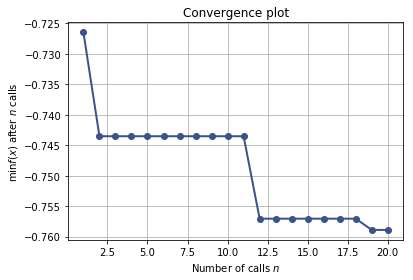

In [12]:
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence
plot_convergence(search_result)
plt.show()

In [20]:
search_result.x
print("The best vector size: %s        the best min count: %s" % (search_result.x[0], search_result.x[1]))

The best vector size: 495        the best min count: 1
